<a href="https://colab.research.google.com/github/visheshgupta19/Explainable-Techniques-II/blob/main/Explainable_Techniques_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-ny9qptn6/alepython_aed1a19493034345a527c32e20770e5b
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-ny9qptn6/alepython_aed1a19493034345a527c32e20770e5b
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done


In [2]:
!pip install PyALE

In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from alepython import ale_plot
from PyALE import ale

We are working with classic heart disease dataset where each row is a patient record.

Our attributes are as follows:
- Attributes (13 features + 1 label):
  
  Demographic:
  - age: Patient’s age (numeric).
  - sex: Binary (1 = male, 0 = female).

  Clinical measurements:
  - trestbps: Resting blood pressure (numeric).
  - chol: Serum cholesterol (numeric).
  - thalach: Max heart rate achieved (numeric).
  - oldpeak: ST depression induced by exercise (numeric).

  Binary indicators:
  - fbs: Fasting blood sugar > 120 mg/dl (1/0).
  - exang: Exercise-induced angina (1/0).

  Categorical (ordinal/nominal):
  - cp: Chest pain type (0–3).
  - restecg: Resting ECG results (0–2).
  - slope: Slope of ST segment (0–2).
  - ca: Number of major vessels (0–3).
  - thal: 0 = normal, 1 = fixed defect, 2 = reversible defect.

  Label (Target):
  - condition: 0 = no disease, 1 = disease.

The above description was provided through chatgpt by given it a prompt of: 'The columns in my data are as follows: column -> what they indicate. Give me a structured format for my google colab text file'

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/visheshgupta19/Explainable-Techniques-II/refs/heads/main/heart_cleveland_upload.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [5]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition'],
      dtype='object')

# Initial EDA

In [6]:
# general analysis
print(df.shape)
print('--------------')
print(df.info())
print('--------------')
print(df.describe())

(297, 14)
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB
None
--------------
              age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000

In [7]:
# we are looking at condition as target variable
df["condition"].value_counts(normalize=True)

,proportion
condition,
0,0.538721
1,0.461279


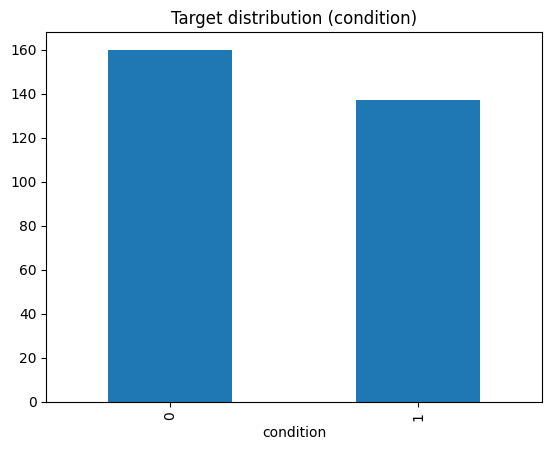

In [8]:
df["condition"].value_counts().plot(kind="bar")
plt.title("Target distribution (condition)")
plt.show()

From the analysis above we see that all values are complete with no missing data. The patients within the dataset have an average age of 54.5 years, and about 68% are male. Our clinical measures show an expected variation with some outliers and our categorical features are covering the full ranges. Our target variable is also well balanced with 53.9% no disease and 46.1% disease. I think from the initial EDA the data looks to be clean and balanced.

Prompt Given to Chat GPT: generate univariate graphs for our numerical and categorical features.

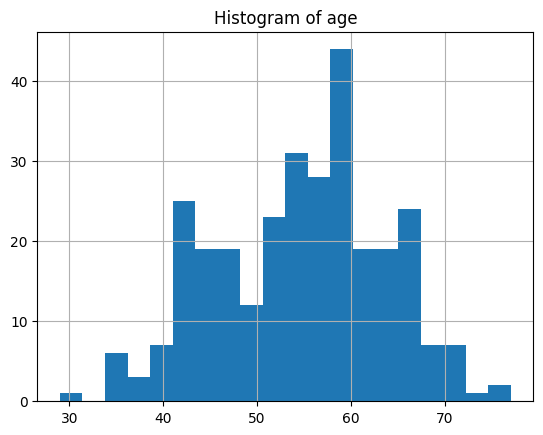

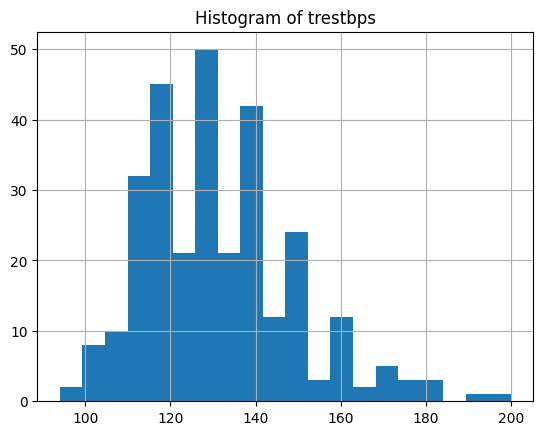

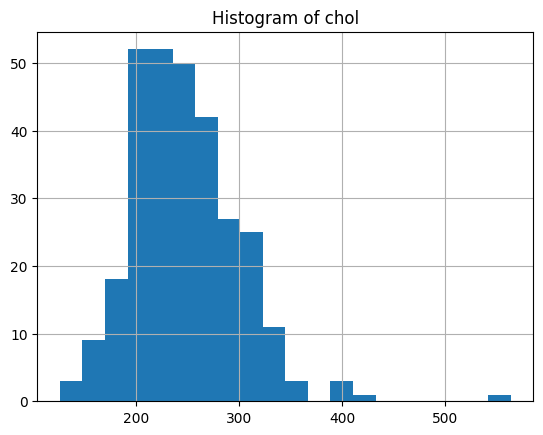

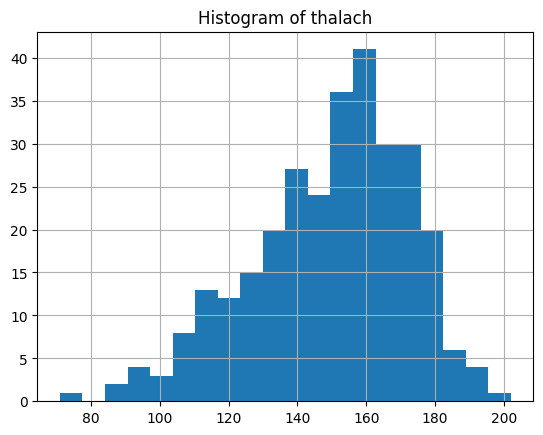

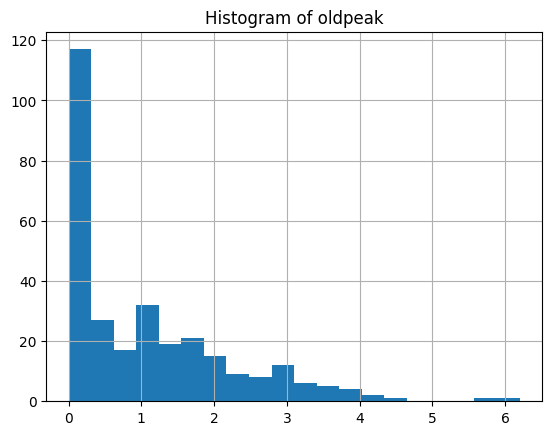

In [9]:
num_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
for col in num_features:
    df[col].hist(bins=20)
    plt.title(f"Histogram of {col}")
    plt.show()

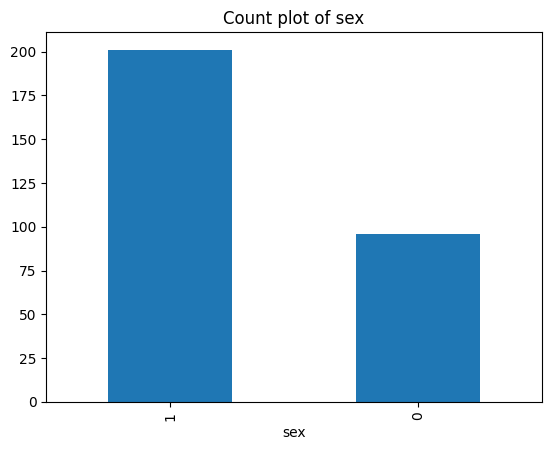

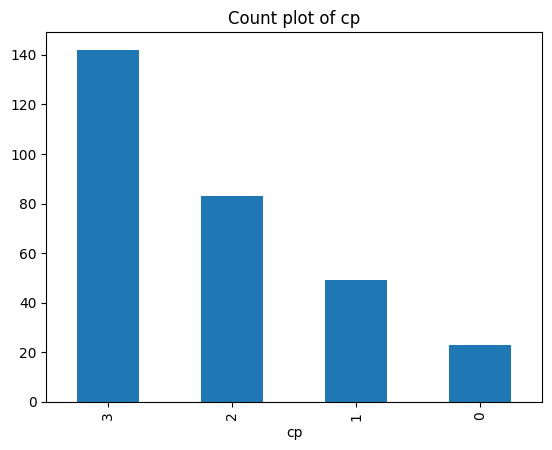

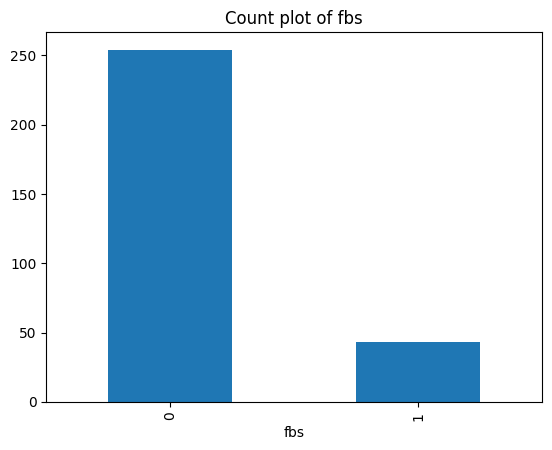

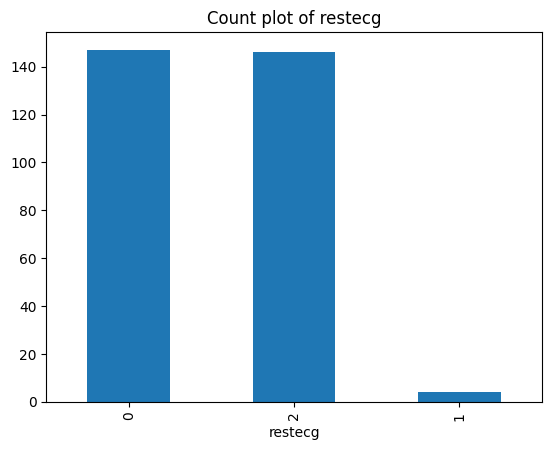

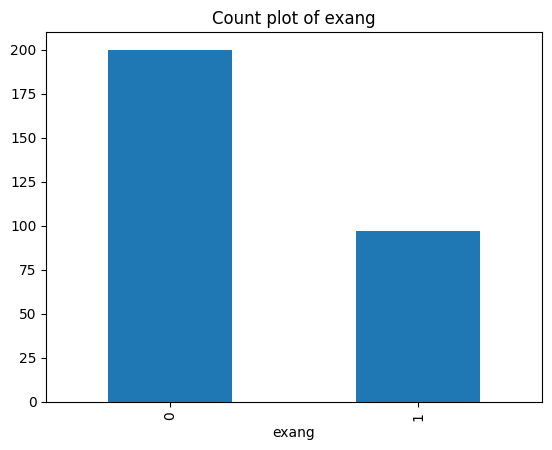

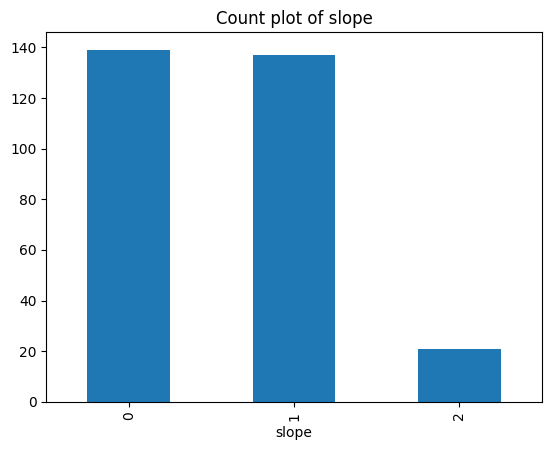

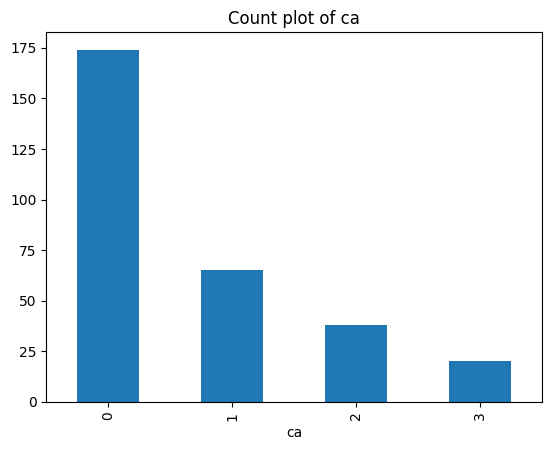

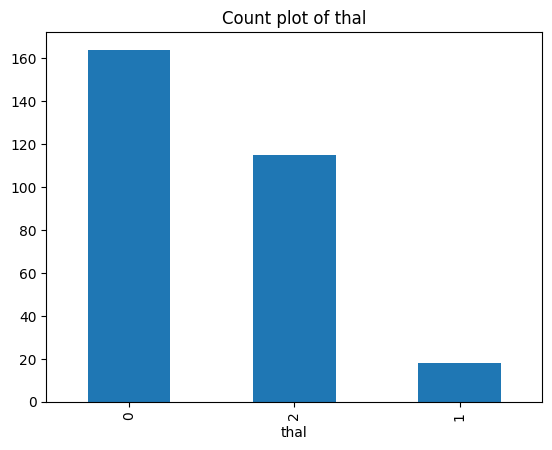

In [10]:
cat_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
for col in cat_features:
    df[col].value_counts().plot(kind="bar")
    plt.title(f"Count plot of {col}")
    plt.show()

Our plots confirm our numeric observations above that the dataset in made up mainly of middle aged male patients. We see age clustering in the 50s-60s. Our numeric features outside of that are general in the normal to high ranges with a few extreme outliers. Among categorical features there seems to be an imbalance across several of them which can have an impact on our modeling.

In [11]:
corr = df[num_features].corr()
print(corr)

               age  trestbps      chol   thalach   oldpeak
age       1.000000  0.290476  0.202644 -0.394563  0.197123
trestbps  0.290476  1.000000  0.131536 -0.049108  0.191243
chol      0.202644  0.131536  1.000000 -0.000075  0.038596
thalach  -0.394563 -0.049108 -0.000075  1.000000 -0.347640
oldpeak   0.197123  0.191243  0.038596 -0.347640  1.000000


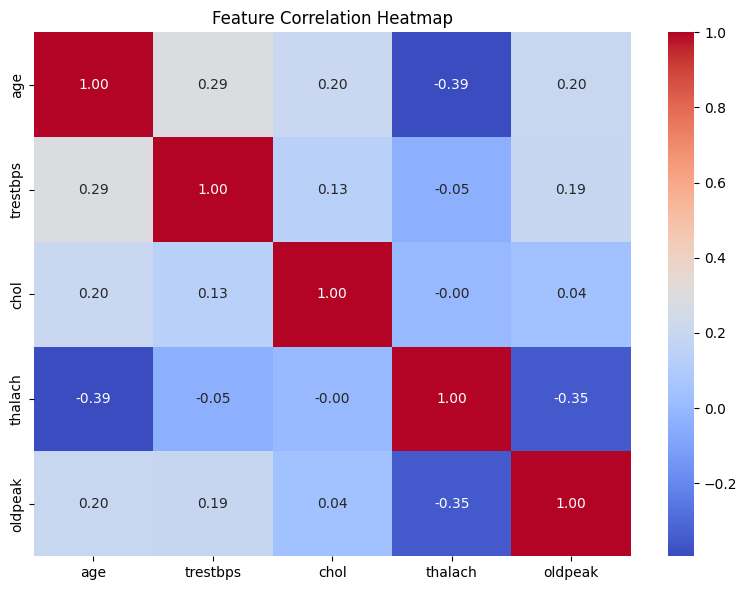

In [12]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm",
)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


From the correlation matrix above we can see that Age and Maximum Heart Rate (thalach) are negatively correlated which makes sense as once a patient gets older they tend to have a lower heart rates during exercise. What is surprising is the relations we see with Cholesterol. It looks like that it has almost no correlation with other numeric features. Overall, throw the matrix I feel like we see no particularly strong linear correlations among the numeric features and the only ones that stand out are that between age and exercise-related measures.

# Model Creation and Feature Selection

In [13]:
X = df.drop("condition", axis=1)
y = df["condition"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

For our features we want to focus on based on our correlation matrix we will pick the following:
- age: This is important for condition
- thalach: Seems to have interaction with age and oldpeak
- oldpeak: relevant for heart conditions and interacts with thalach

In [15]:
features_to_plot = ["age", "thalach", "oldpeak"]

# PDP Plot

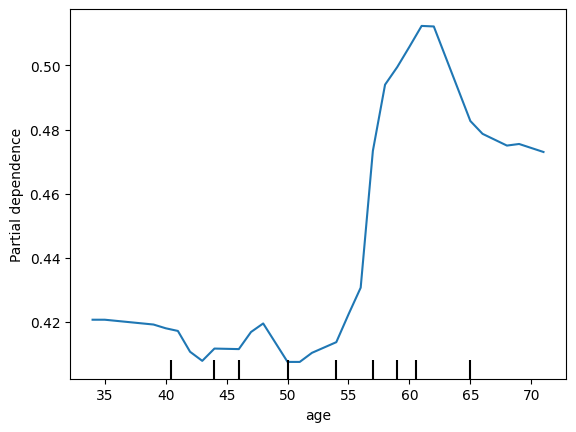

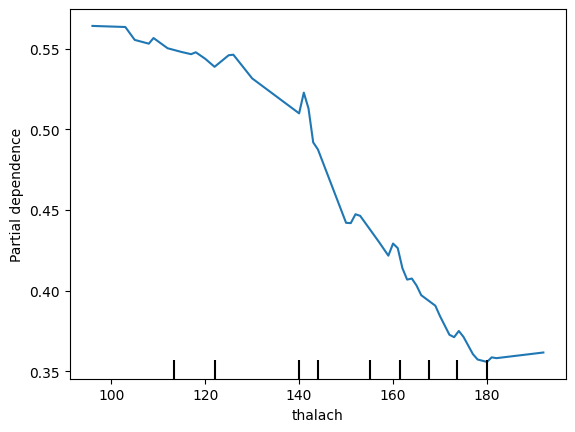

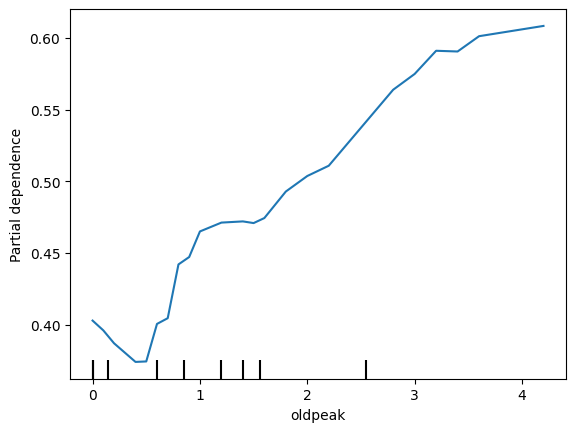

In [16]:
#PartialDependenceDisplay.from_estimator(model, X_test, features_to_plot, kind='average')
# this code was taken from Dr.Bent's explanations notebook on github

for i in features_to_plot:
  PartialDependenceDisplay.from_estimator(model, X_test, [i], kind='average')

The PDPs for our features are showing us the following:

1. Age:
- The relationship is non linear. At an early age i.e. 25-50 years the effect is relatively flat showing a low influence however between 55-62 years the probability sees a sharp increase and then declines again beyond 65 years. This indicates that middle aged to young old age individuals are more likely to have heart disease.
- I find the plateau post 65 years extremely interesting and this could possibly indicate a bias in our dataset that is on the grounds of our data having healthier than average old people or it could also indicate a small sample size in the older ranges which needs to be looked into more depth.

2.  Thalach:
- There seems to be a clear relation that the dependance in decreasing with increase in thalach. This tells us that patients achieving higher maximum heart rates during exercise are less likely to have heart disease which I believe aligns with my medical thinking.

3. oldpeak:
- Similar to Thalach there seems to be a clear relation that the dependance in increasing with increase in oldpeak. This would indicate that more exercise induced ST depression is associated with higher likelihood of heart disease.

My overall takeaway from the above is that age shows a nonlinear effect with peak risk around 55–62 which thalach having an inverse relation with risk of heart disease and old break have a direct relationship with the same.

# ICE Plots

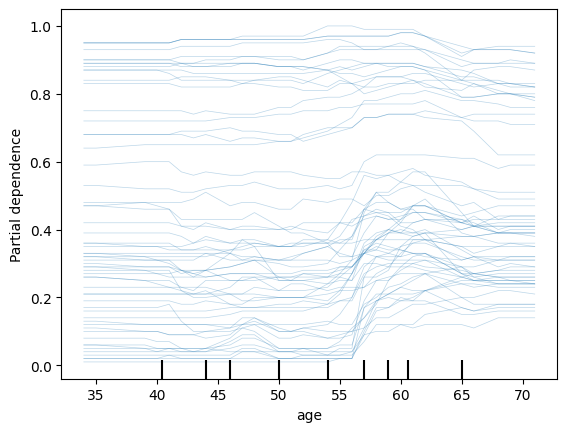

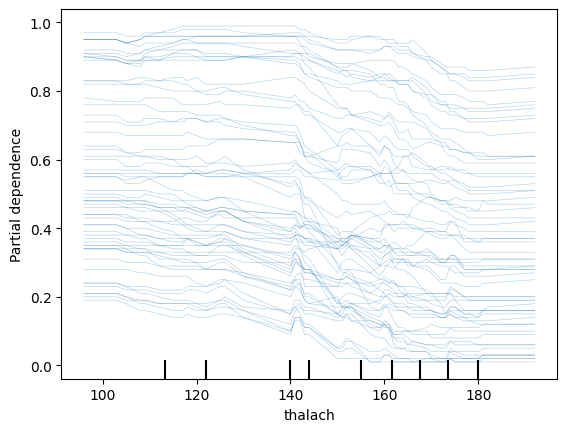

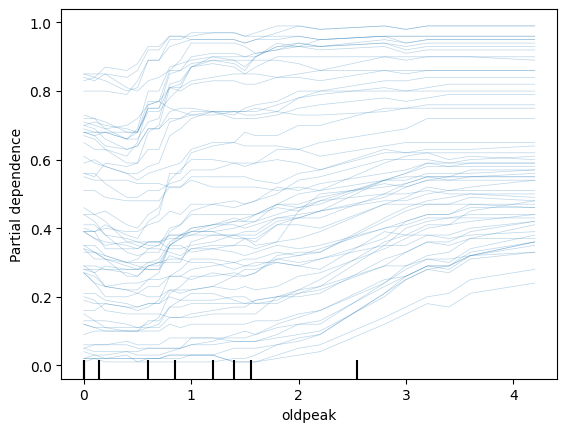

In [17]:
# Use PartialDependenceDisplay to display the ICE plot
# PartialDependenceDisplay.from_estimator(model, X_test, features_to_plot, kind='individual') #kind='individual'
# this code was taken from Dr.Bent's explanations notebook on github

for i in features_to_plot:
  PartialDependenceDisplay.from_estimator(model, X_test, [i], kind='individual')

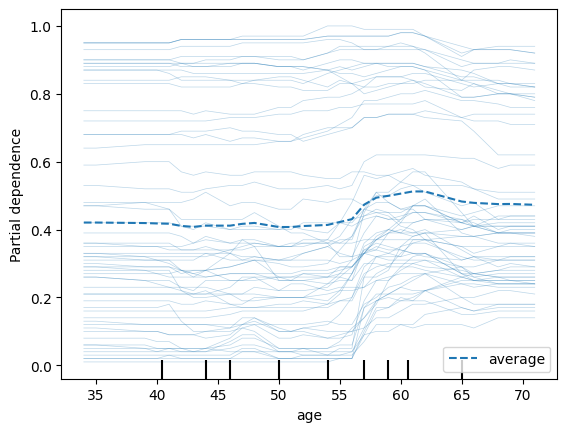

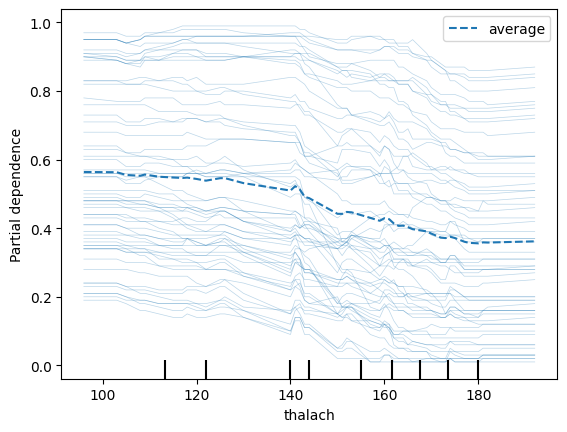

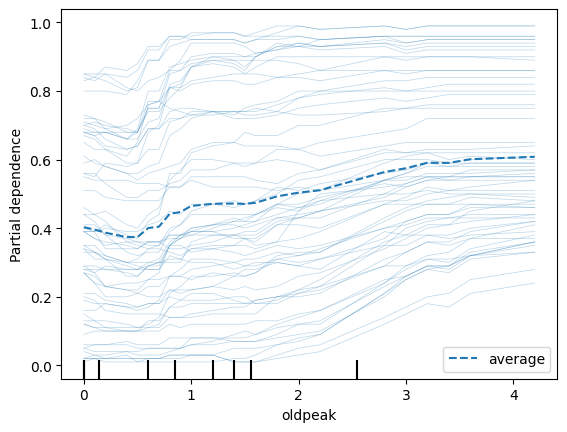

In [18]:
# Use PartialDependenceDisplay to display the ICE plot and the PDP overlayed on top
# PartialDependenceDisplay.from_estimator(model, X_test, features_to_plot, kind='both') #kind='both'
# this code was taken from Dr.Bent's explanations notebook on github
for i in features_to_plot:
  PartialDependenceDisplay.from_estimator(model, X_test, [i], kind='both')

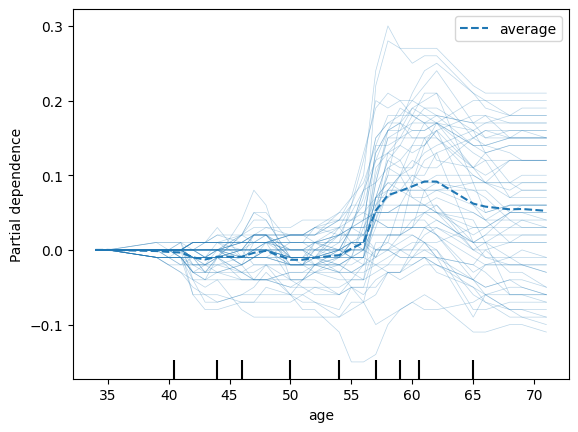

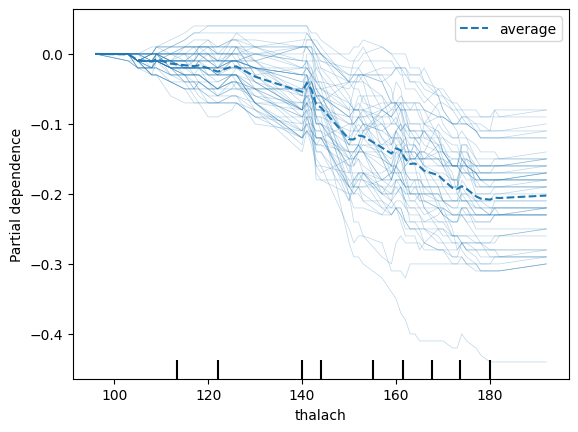

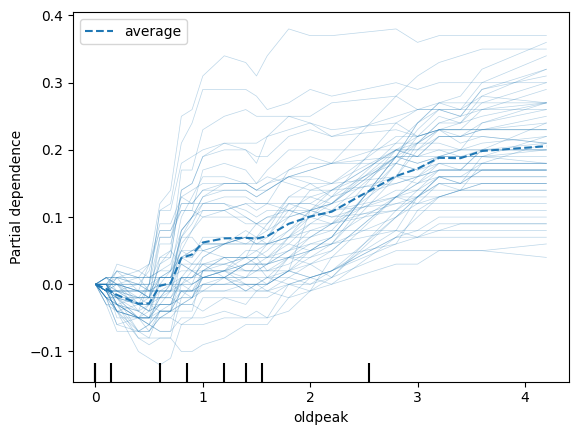

In [19]:
# Centered ICE plots (c-ICE)
# PartialDependenceDisplay.from_estimator(model, X_test, features_to_plot, kind='both', centered=True)
# this code was taken from Dr.Bent's explanations notebook on github

for i in features_to_plot:
  PartialDependenceDisplay.from_estimator(model, X_test, [i], kind='both', centered=True)

When we are looking at our centered ICE Plots we see the following:
1. Age:
- Till around 55 years the partial dependence stays close to 0, which shows us little impact on the predicted probability of the condition. However after 55 there is a positive effect that is seen which indicates that the model associates it with a higher likelihood of the condition. Eventually this ends up flattening post 65 years with a partial dependence of around 0.05

2. Thalach:
- We see there is a clear downward trend. As the maximum heart rate increase the average predicted probability of heart disease decreases. From this we can conclude that patients achieving higher maximum heart rates during exercise are less likely to have heart disease which I believe aligns with my medical thinking.

3. Oldpeak:
- We can see an initial dip for 0 to a tad bit before 1 however after that the partial dependence increases steadily and strongly. This indicates that the higher the oldpeak, the higher the model’s predicted risk and this trend stays in a consistent manner.

# ALE Plots

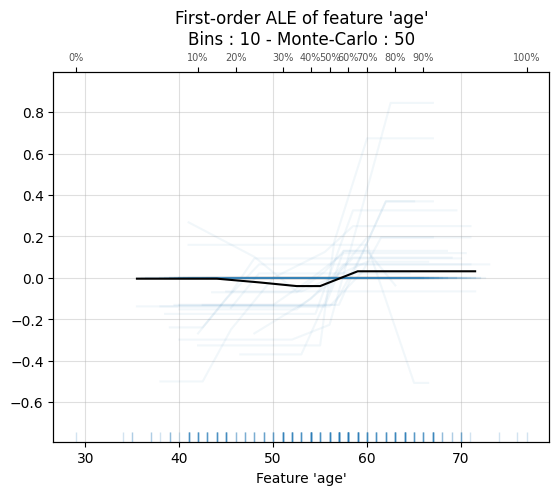

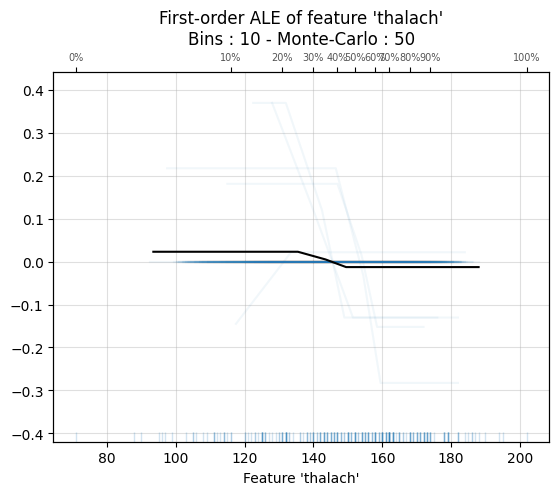

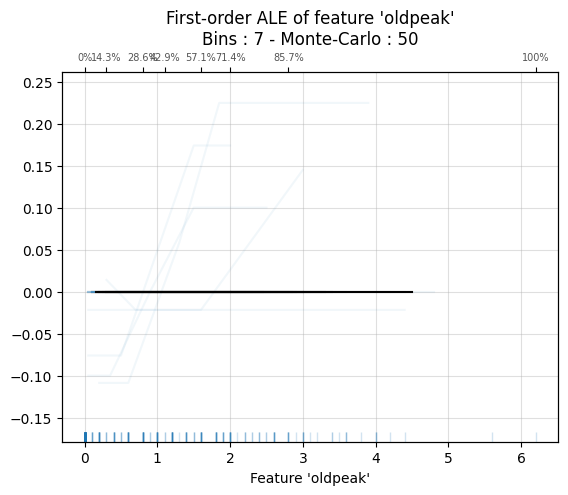

In [20]:
# this code was taken from Dr.Bent's explanations notebook on github
for i in features_to_plot:
  ale_plot(model, X_train, i, monte_carlo=True)

Looking at our ALE plots above we see:

1. Age:
- There is a strong clear almost linear relationship that can be seen. This indicates that as a patients age increases the models prediction for the likelihood of a heart disease also increases slowly. Based on that we can conclude based on the graph that a 30 yr old is at lower risk while a 70 yr old has increase risk. I believe that this is one of the most influential features in the model.

2. Thalach:
- There seems to be a negative relationship. This aligns with our previous finding as when the maximum heart rate achieved increases, the model's prediction for heart disease decreases. It is also visible that this feature effects tends to plateau on both extremes.

3. Oldpeak:
- It seems like the ALE line is flat across 0 which indicates that there is no meaningful effect of the feature. It has little to no consistent effect on the models prediction. This indicates that while the feature is medically relevant for the model I have created it isn't relied on that heavily.

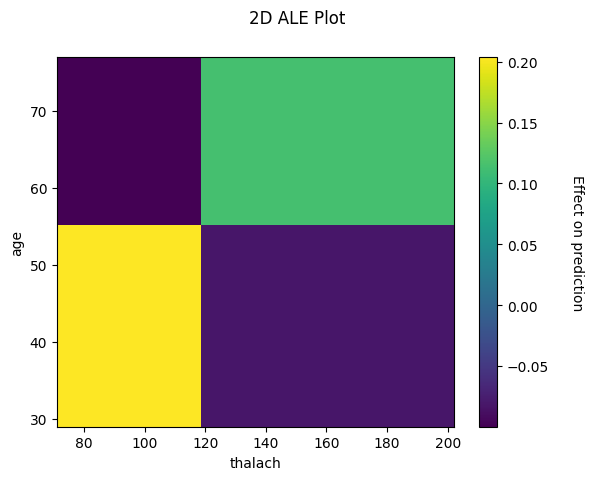

In [21]:
'''
I was unable to generate the 2D plot based on the github code provided to us so I asked GPT. Other ways to generate this code given the following error:
---------------------------------------------------------------------------
NotImplementedError                       Traceback (most recent call last)
/tmp/ipython-input-3203955297.py in <cell line: 0>()
      3
      4 # Create 2D ALE plot for two features
----> 5 ale_plot(model, X_train, ['age', 'thalach'], monte_carlo=True)

2 frames
/usr/local/lib/python3.12/dist-packages/scipy/interpolate/_interpolate.py in __init__(self, x, y, z, kind, copy, bounds_error, fill_value)
    146     def __init__(self, x, y, z, kind='linear', copy=True, bounds_error=False,
    147                  fill_value=None):
--> 148         raise NotImplementedError(err_mesg)
    149
    150

NotImplementedError: `interp2d` has been removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
https://scipy.github.io/devdocs/tutorial/interpolate/interp_transition_guide.html
'''

ale_2d = ale(
    X=X_train,
    model=model,
    feature=["age", "thalach"],
    grid_size=10,
)

NEED TO WRITE AN EXPLANATION FOR THIS